**Project Introduction**<p>
This project is a practice to train different models and predict hotel performances. The dataset is an one year long hotel performance data that I mimic the real world situation with random number adjustments. (Currency: NT$)</br>
這個專案使用一個模仿現實飯店營運的每日數據資料，來練習及預測飯店績效，數據長度為一年共365天。<p>
_Columns description 欄位名稱說明_</br>
rn=Room Nights, adr=Average Daily Rate, rev=Revenue, occ=ocupancy rate(%), fit=Free/Independent Traveller, git=Groups/Travel Agency, corp=Contract rates with companies/corperates, ttl=total</br>
rn=住房數, adr=日均價, rev=營收, occ=住房率(%), fit=一般旅客, git=旅行社/團體旅客, corp=商務旅客, ttl=總計<p>
_Definition 定義_</br>
Occ% 住房率 = Occupied rooms(Room nights) 住房數 / Total Available Rooms 總房數 * 100%</br>
Revenue 營收 = Occupied rooms(Room nights) 住房數 * ADR 日均價</br>
RevPAR = Revenue 營收 / Total Available Rooms 總房數 = Occ% 住房率 * ADR 日均價 (Note: RevPAR = Revenue Per Available Rooms)</br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import tree

hotel = pd.read_csv('Mock_Hotel_daily.csv')

###Understanding the data
print(hotel.head())
print(hotel.info())
print(hotel.daytype.value_counts(dropna=False))
print(hotel.special_event.value_counts(dropna=False))

       date dayofweek  daytype special_event  rn_fit  rn_git  rn_corp  \
0  2023/1/1       Sun  holiday           NaN     227      11        2   
1  2023/1/2       Mon     peak           NaN     114       1        7   
2  2023/1/3       Tue  weekday           NaN      59       8       11   
3  2023/1/4       Wed  weekday           NaN      59       0       15   
4  2023/1/5       Thu  weekday           NaN      62      70       17   

   adr_fit  adr_git  adr_corp  rev_fit  rev_git  rev_corp  rn_ttl  adr_ttl  \
0    12956     8190      2028  2940985    90089      4055     240    12646   
1     5292     5356      1905   603342     5356     13335     122     5099   
2     3840     2361      2448   226576    18892     26925      78     3492   
3     3846        0      2486   226924        0     37296      74     3571   
4     4371     1939      1818   271014   135750     30910     149     2937   

   rev_ttl  occ  
0  3035128   83  
1   622033   42  
2   272393   27  
3   264220   25  
4 

Index(['rn_fit', 'rn_git', 'rn_corp', 'rev_ttl', 'occ', 'month', 'day',
       'dayofweek_Fri', 'dayofweek_Mon', 'dayofweek_Sat', 'dayofweek_Thu',
       'dayofweek_Tue', 'dayofweek_Wed', 'daytype_holiday', 'daytype_peak',
       'special_event_neg', 'special_event_pos'],
      dtype='object')


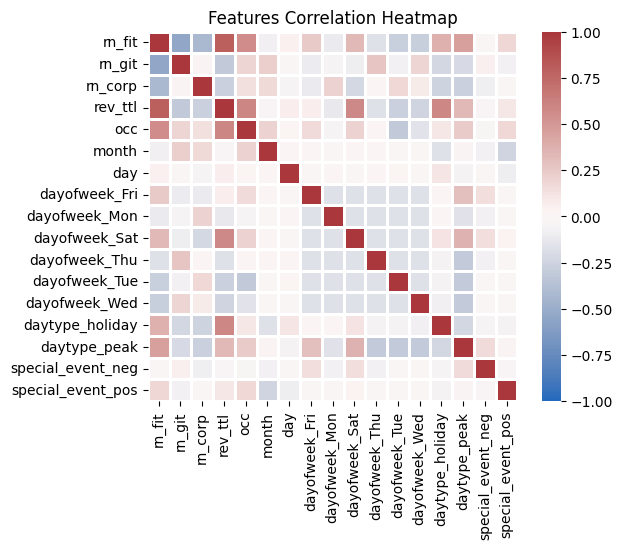

In [3]:
###EDA
hotel['month'] = [x[1] for x in hotel.date.str.split('/')]
hotel['day'] = [x[2] for x in hotel.date.str.split('/')]
hotel = hotel.drop(['date'], axis=1)

hotel_mlr = pd.get_dummies(data=hotel, columns=['dayofweek', 'daytype', 'special_event'])
hotel_mlr = hotel_mlr.drop(['dayofweek_Sun', 'daytype_weekday', 'adr_fit', 'adr_git', 'adr_corp', 'adr_ttl', 'rn_ttl', 'rev_fit', 'rev_git', 'rev_corp'], axis=1)
print(hotel_mlr.columns)

#heatmap
corr = hotel_mlr.corr()
sns.heatmap(corr, cmap='vlag', vmin=-1.0, vmax=1.0, square=True, linecolor='white', linewidths=1.0)
plt.title('Features Correlation Heatmap')
plt.show()

**Part 1. Predicting Revenue 預測營收**</br>
The goal of this project is to predict performance and revenue is one of major performance for a hote. In addition, we are able to further calculate some other major stats such as ADR and RevPAR using revenue.</br>
營收是飯店績效的主要指標之一，同時也可以利用營收來計算其他指標如日均價及RevPAR。

In [5]:
###Predicting Revenue

#Based on heatmap, removing 'month', 'day', 'special_event' to reduce features. 
X = hotel_mlr[['rn_fit', 'rn_git', 'rn_corp', 'occ', 'dayofweek_Fri', 'dayofweek_Mon', 'dayofweek_Sat', 'dayofweek_Thu',
       'dayofweek_Tue', 'dayofweek_Wed', 'daytype_holiday', 'daytype_peak']].values
y = hotel_mlr[['rev_ttl']].values.ravel()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Simple function for predicting and calculating stats
def prediction(model, model_name, new_data):
    pred_rev = np.round(model.predict(new_data))
    pred_adr = np.round([pred_rev[i]/(new_data[i][0]+new_data[i][1]+new_data[i][2]) for i in range(len(pred_rev))])
    pred_revpar = np.round([new_data[i][3]*pred_adr[i]*0.01 for i in range(len(pred_rev))])
    table_rev = pd.DataFrame(pred_rev, columns=[f'{model_name}_revenue'])
    table_adr = pd.DataFrame(pred_adr, columns=[f'{model_name}_adr'])
    table_revpar = pd.DataFrame(pred_revpar, columns=[f'{model_name}_revpar'])
    table = pd.concat([table_rev, table_adr, table_revpar], axis=1)
    return table

#Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)
print(f'Multiple Linear Regression Train Score: {mlr.score(x_train, y_train), 0}')
print(f'Multiple Linear Regression Test Score: {mlr.score(x_test, y_test), 0}')

#Predicting couple days, 10/22/2024, 06/21/2024, 04/05/2024
new_dates = ['10/22/2024', '06/21/2024', '04/05/2024']
new_days = [[78, 36, 42, 54, 0, 0, 0, 0, 1, 0, 0, 0], 
            [166, 32, 19, 75, 1, 0, 0, 0, 0, 0, 0, 1],
            [202, 21, 16, 83, 0, 0, 0, 0,1, 0, 1, 0]]

mlr_pred = prediction(mlr, 'mlr', new_days)

#Random Forest Regression
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
print(f'Random Forest Regression Train Score: {rfr.score(x_train, y_train)}')
print(f'Random Forest Regression Test Score: {rfr.score(x_test, y_test)}')

#Using same days for predicting
rfr_pred = prediction(rfr, 'rfr', new_days)

new_table = pd.concat([pd.DataFrame(new_dates, columns=['date']), mlr_pred, rfr_pred], axis=1)
print(new_table)

Multiple Linear Regression Train Score: (0.8867754631378716, 0)
Multiple Linear Regression Test Score: (0.8762126795961975, 0)
Random Forest Regression Train Score: 0.9845266135652028
Random Forest Regression Test Score: 0.86462539545721
         date  mlr_revenue  mlr_adr  mlr_revpar  rfr_revenue  rfr_adr  \
0  10/22/2024     483615.0   3100.0      1674.0     518756.0   3325.0   
1  06/21/2024    1088389.0   5016.0      3762.0    1064294.0   4905.0   
2  04/05/2024    2270920.0   9502.0      7887.0    2286198.0   9566.0   

   rfr_revpar  
0      1796.0  
1      3679.0  
2      7940.0  


**Part 2. Classifying over or under 60% occupancy 針對住房率60%分群**</br>
I am classifying days under 60% using day of the month, day of week, day type and special event as features. The purpose is to see if I can find some helpful information related to slow day so that we may pay more attention on those days. Since room nights directly contribute to occupancy, I will not include it here.
這裡我利用日期、星期、假別、特殊事件來進行分群，目的是為了尋找是否可以獲得有用的資訊，來分辨出什麼情況下可能會有低住房率，進而在未來可以多留意這些情況。

Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Depth: 17
Train Accuracy: 0.9417808219178082
Test Accuracy: 0.8082191780821918


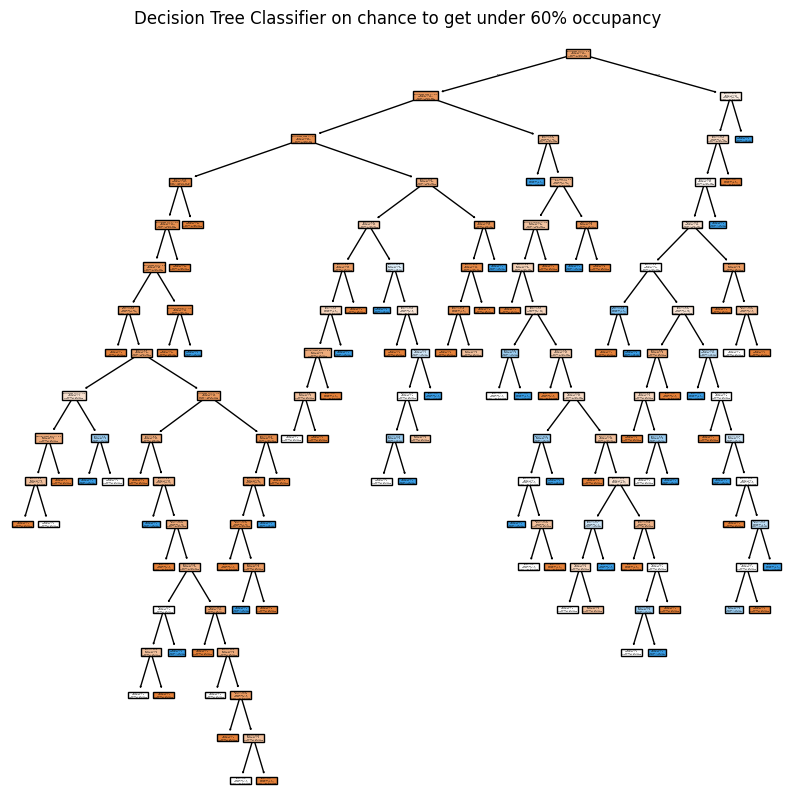

The best test score: 0.8356164383561644 with ccp 0.0036366601435094577


C:\Users\Fenrir\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(ccp_alpha=0.0036366601435094577, max_depth=4,
                       min_samples_leaf=2, min_samples_split=5)
Best max_depth: 4
Best max_samples_leaf: 2
Best max_samples_split: 5
Best score: 0.8254237288135593
Train Accuracy: 0.839041095890411
Test Accuracy: 0.821917808219178


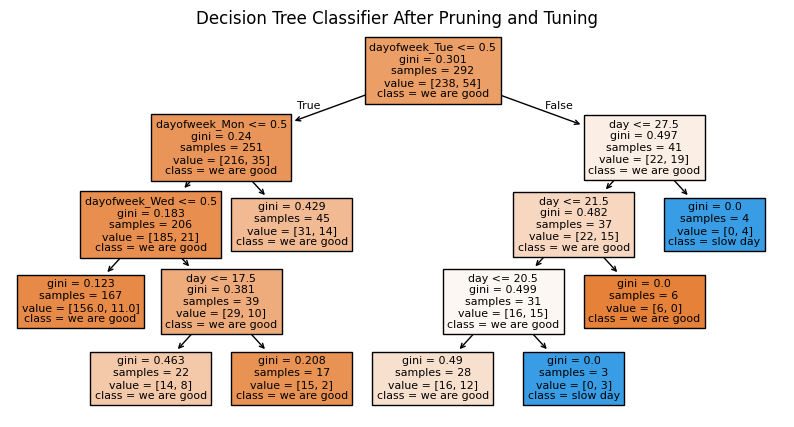

In [7]:
###We have a slow day (chance to have under 60% occupancy)
hotel_dt = pd.get_dummies(data=hotel, columns=['dayofweek', 'daytype', 'special_event'])
hotel_dt = hotel_dt.drop(['dayofweek_Sun', 'daytype_weekday'], axis=1)

X = hotel_dt[['day', 'dayofweek_Fri', 'dayofweek_Mon', 'dayofweek_Sat', 'dayofweek_Thu',
       'dayofweek_Tue', 'dayofweek_Wed','daytype_holiday', 'daytype_peak', 'special_event_neg', 'special_event_pos']].values
y = hotel_dt['occ'] < 60
feature_names = ['day', 'dayofweek_Fri', 'dayofweek_Mon', 'dayofweek_Sat', 'dayofweek_Thu',
       'dayofweek_Tue', 'dayofweek_Wed','daytype_holiday', 'daytype_peak', 'special_event_neg', 'special_event_pos']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print(f'Parameters: {dt.get_params()}')
print(f'Depth: {dt.get_depth()}')
print(f'Train Accuracy: {dt.score(x_train, y_train)}')
print(f'Test Accuracy: {dt.score(x_test, y_test)}')

plt.figure(figsize=[10, 10])
tree.plot_tree(dt, feature_names = feature_names, class_names = ['we are good', 'slow day'], filled=True)
plt.title('Decision Tree Classifier on chance to get under 60% occupancy')
plt.tight_layout
plt.show()

#Pruning
best_score = 0
best_ccp = 0
path = dt.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
for i in ccp_alphas:
    dt = DecisionTreeClassifier(ccp_alpha=i)
    dt.fit(x_train, y_train)
    score = dt.score(x_test, y_test)
    if score > best_score:
        best_score = score
        best_ccp = i
        
print(f'The best test score: {best_score} with ccp {best_ccp}')

#Tuning
parameters = {'max_depth': range(3, 10), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10)}
dt = DecisionTreeClassifier(ccp_alpha=best_ccp)
gscv= GridSearchCV(dt, parameters)
gscv.fit(x_train, y_train)
print(gscv.best_estimator_)

print('Best max_depth: {}'.format(gscv.best_params_['max_depth']))
print('Best max_samples_leaf: {}'.format(gscv.best_params_['min_samples_leaf']))
print('Best max_samples_split: {}'.format(gscv.best_params_['min_samples_split']))
print('Best score: {}'.format(gscv.best_score_))

#Based on the pruning and Tuning
dt = DecisionTreeClassifier(ccp_alpha=best_ccp, max_depth=gscv.best_params_['max_depth'], min_samples_leaf=gscv.best_params_['min_samples_leaf'], min_samples_split=gscv.best_params_['min_samples_split'])
dt.fit(x_train, y_train)
print(f'Train Accuracy: {dt.score(x_train, y_train)}')
print(f'Test Accuracy: {dt.score(x_test, y_test)}')

plt.figure(figsize=[10, 5])
tree.plot_tree(dt, feature_names = feature_names, class_names = ['we are good', 'slow day'], filled=True)
plt.title(f'Decision Tree Classifier After Pruning and Tuning')
plt.tight_layout
plt.show()


**Part 3. Finding amount of day type group 尋找適合的假別數量**</br>
Currently we have 3 groups of day type, weekday, peak, and holiday, and we set price based on it. I want to know should there be more groups so that our price strategy could be more accurate? Meanwhile, I don't want to get too many groups and being complex, so I limit it within 10.</br>
目前這個數據資料僅區分3個假別，分別是平日、週末、連續假期，並以此來制定價格策略，我想知道是否有需要設定更多的假別，因此我直接對主要績效指標的日均價及住房率，來做unsupervised machine learning，但我不想有過多的假別造成太過複雜的價格策略，因此我設定限制最多10個。

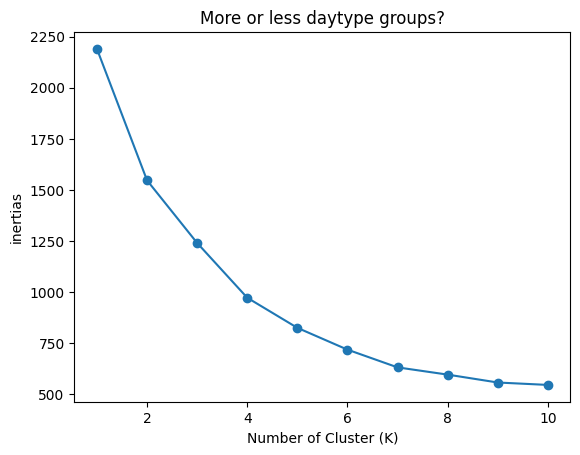

In [9]:
###Classify day type groups

#Scaling
hotel_km = hotel[['rn_fit', 'rn_git', 'rn_corp', 'adr_fit', 'adr_git', 'adr_corp']]
st_sc = StandardScaler()
st_sc.fit(hotel_km)
hotel_km = st_sc.transform(hotel_km)
num_cluster = range(1, 11)

#K-mean
inertias = []
for i in num_cluster:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(hotel_km)
    inertias.append(kmeans.inertia_)

plt.plot(num_cluster, inertias, '-o')
plt.title('More or less daytype groups?')
plt.xlabel('Number of Cluster (K)')
plt.ylabel('inertias')
plt.show()


**Conclusion 結論**<p>
_Part 1. Predicting Revenue 預測營收_</br>
Both Multiple Linear Regression and Random Forest Regression work well on predicing revenue, and the numbers make sense at different day type.</br>
我訓練了多元線性回歸和隨機森林回歸，並預測三個不同假別的日期，預測出的營收和計算出的指標數值是合理的。<p>
_Part 2. Clissifying over or under 60% occupancy 針對住房率60%分群_</br>
In this part, I am classifying slow days which occupacy is under 60% so that we may pay more attention on those days in the future. At first the tree is overfitting. Therefore I prun and tune the tree to make it better. Based on the tree, I think we may pay more attention on Tuesday during first and last couple days of the month. However, the tree doesn't provide much more helpful information, I think day of month, day of week, day type and special event may not well enough or related enough to classify occupancy.</br>
(Note that I set random_state=2, the tree and result may look different with different random_state setting.)</br>
在這個部分，我訓練決策樹來進行分群，試圖尋找什麼情況下會有低住房率，在一開始時決策樹overfitting，因此我進行剪枝來改進，就結果來看月初和月低的週二是容易有低住房率的，需要特別留意。除此之外，並未找到太多有用的資訊，可能單憑日期、星期、假別、特殊事件，並不能很好的去區分出低住房率的日子。</br>
(這裡我指定random_state=2，但在不同的設定下可能會有不同的決策樹和結論。)<p>
_Part 3. Finding amount of day type group 尋找適合的假別數量_</br>
The result shows that 6-8 may be a better number. We may consider split friday, saturday, sunday from peak, or create another weekday/peak set for peak season such as summer break and winter break. This approach may also improve the accuracy of Part 1 and Part 2.</br>
這部分的結果顯示，將假別增加至6-8種是比較合適的，或許可以考慮將週六從週末類別拆出，或者是針對寒暑假旺季，設定另外一組平日/週末/連續假日。